Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# 1. Подготовка данных

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import copy
df = pd.read_csv('/datasets/autos.csv')
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


In [3]:
#добавлю тэг категориальным для дальнейшего удобства и отброшу даты
df.columns = ['DateCrawled', 'Price', 'VehicleType_cat', 'RegistrationYear', 'Gearbox_cat',
       'Power', 'Model_cat', 'Kilometer', 'RegistrationMonth', 'FuelType_cat', 'Brand_cat',
       'Repaired_cat', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen']

df= df.drop(['DateCrawled','DateCreated','LastSeen'], axis=1)

Посмотрим на количество нанов и их процентное соотношение:

In [4]:
def table (df):  
    x = pd.DataFrame()
    x['Всего NaN'] = df.isna().sum()
    x['% NaN'] = x['Всего NaN'] / df.shape[0]
    return x.sort_values('% NaN', ascending=False)

table(df).head(10)

,Всего NaN,% NaN
Repaired_cat,71154,0.200791
VehicleType_cat,37490,0.105794
FuelType_cat,32895,0.092827
Gearbox_cat,19833,0.055967
Model_cat,19705,0.055606
Price,0,0.000000
RegistrationYear,0,0.000000
Power,0,0.000000
Kilometer,0,0.000000
RegistrationMonth,0,0.000000


И вот тут бы я хотела попробовать два пути.
1. Не предобрабатывать данные вообще, удалив только пропуски. Я хочу попробовать сделать ее более помехоустойчивой, обучив ее на "плохих" данных. Очевидно, качество предсказания от этого может сильно пострадать.
2. Предобработать данные как обычно и обучить модель на них.

Обучим модель на обоих датасетах и сравним качество и способность каждой модели к переобучению

In [5]:
bad_df = copy.deepcopy(df)
bad_df = bad_df.dropna()

In [6]:
df['Repaired_cat'].value_counts()

no     247161
yes     36054
Name: Repaired_cat, dtype: int64

In [7]:
df['Repaired_cat'].unique().shape[0]

3

Если следовать описанию, то верная трактовка столбца NotRepaired будет такова: yes (True) - не ремонтировались, no (False) - ремонтировались. Но это столбец с самым большим количеством пропусков. Выглядит так, будто люди не нажимали этот "чекбокс", думая что отсутствие отметки = отсутствие ремонта, хотя по логике описания столбца должно быть иначе. Ну и пропусков 71 тысяча, что практически в 2 раза превышает количество отмеченных правильно yes, 36 тысяч. Таким образом, если мы добавим пропуски так, как следует логике, мы увеличим количество значений почти в 3 раза. Дропать 20 % датасета из-за этих пропусков мне также кажется неправильным. Попробую последовать логике людей - переименую столбец с NotRepaired на Repaired (уже выше) и заполню NaN-ы на значение 'no' - не ремонтировалась.

In [8]:
df['Repaired_cat'] = df['Repaired_cat'].fillna('no')
df['Repaired_cat'].value_counts()

no     318315
yes     36054
Name: Repaired_cat, dtype: int64

In [9]:
df['VehicleType_cat'].value_counts()

sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: VehicleType_cat, dtype: int64

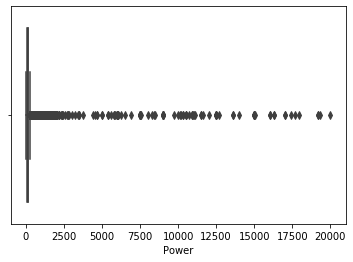

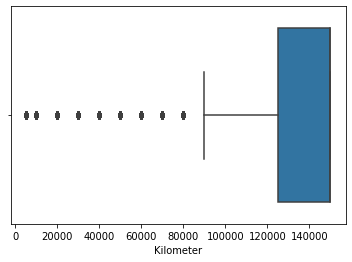

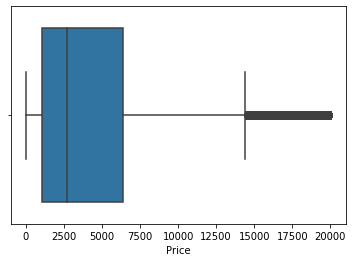

In [10]:
df['Model_cat'] = df['Model_cat'].fillna('unknown')
df['VehicleType_cat'] = df['VehicleType_cat'].fillna('unknown')
df['FuelType_cat'] = df['FuelType_cat'].fillna('unknown')
df['Gearbox_cat'] = df['Gearbox_cat'].fillna('unknown')
import seaborn as sns
import matplotlib.pyplot as plt
for x in ['Power','Kilometer','Price']:
    sns.boxplot(df[x]) 
    plt.show()

Ограничим явные аномалии в столбце с ценой. Нули в цене и мощности заполним средним значением по каждому виду модели машин:

In [11]:
df = df.query('Price < 14000')
df = df.query('Price != 1')
power_pivot = df.pivot_table(columns='Model_cat', values='Power', aggfunc='mean').astype('int').to_dict()
price_pivot = df.pivot_table(columns='Model_cat', values='Price', aggfunc='mean').astype('int').to_dict()

In [12]:
def fill_zero(row, category, where, pivot_table):
    x = row[category]
    y = pivot_table[x][where]
    if row[where] == 0:  
        row[where] = y
    return row
        
df = df.apply(fill_zero, axis=1, args=('Model_cat','Power', power_pivot))
df = df.apply(fill_zero, axis=1, args=('Model_cat','Price', price_pivot))

df.head(10)

,Price,VehicleType_cat,RegistrationYear,Gearbox_cat,Power,Model_cat,Kilometer,RegistrationMonth,FuelType_cat,Brand_cat,Repaired_cat,NumberOfPictures,PostalCode
0,480,unknown,1993,manual,94,golf,150000,0,petrol,volkswagen,no,0,70435
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,no,0,90480
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,0,91074
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,0,60437
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,0,33775
6,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,0,67112
7,3557,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,0,19348
9,999,small,1998,manual,101,golf,150000,0,unknown,volkswagen,no,0,27472
10,2000,sedan,2004,manual,105,3_reihe,150000,12,petrol,mazda,no,0,96224
11,2799,wagon,2005,manual,140,passat,150000,12,gasoline,volkswagen,yes,0,57290


Закончим предобработку: уберем нулевые строки с мощностью тех моделей, которые не попали в словарь(там остались нули), ограничим нижний предел с ценой до 100 евро

In [13]:
df = df.query('Power != 0')
df = df.query('Price > 100')

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 330600 entries, 0 to 354368
Data columns (total 13 columns):
Price                330600 non-null int64
VehicleType_cat      330600 non-null object
RegistrationYear     330600 non-null int64
Gearbox_cat          330600 non-null object
Power                330600 non-null int64
Model_cat            330600 non-null object
Kilometer            330600 non-null int64
RegistrationMonth    330600 non-null int64
FuelType_cat         330600 non-null object
Brand_cat            330600 non-null object
Repaired_cat         330600 non-null object
NumberOfPictures     330600 non-null int64
PostalCode           330600 non-null int64
dtypes: int64(7), object(6)
memory usage: 35.3+ MB


"Чистый" датасет уменьшился всего на 6.7%

# 2. Обучение и анализ моделей

In [16]:
f_train, f_valid, t_train, t_valid = train_test_split(
    df.drop('Price', axis=1), df.Price, test_size=0.25, random_state=12345)
#del df
f_train.shape[0], f_valid.shape[0], t_train.shape[0], t_valid.shape[0]


(247950, 82650, 247950, 82650)

In [17]:
f_train['VehicleType_cat'] = f_train['VehicleType_cat'].astype('category')
f_train['Gearbox_cat'] = f_train['Gearbox_cat'].astype('category')
f_train['Model_cat'] = f_train['Model_cat'].astype('category')
f_train['FuelType_cat'] = f_train['FuelType_cat'].astype('category')
f_train['Brand_cat'] = f_train['Brand_cat'].astype('category')
f_train['Repaired_cat'] = f_train['Repaired_cat'].astype('category')

f_valid['VehicleType_cat'] = f_valid['VehicleType_cat'].astype('category')
f_valid['Gearbox_cat'] = f_valid['Gearbox_cat'].astype('category')
f_valid['Model_cat'] = f_valid['Model_cat'].astype('category')
f_valid['FuelType_cat'] = f_valid['FuelType_cat'].astype('category')
f_valid['Brand_cat'] = f_valid['Brand_cat'].astype('category')
f_valid['Repaired_cat'] = f_valid['Repaired_cat'].astype('category')

In [18]:
cat_features = [c for c, col in enumerate(f_train.columns) if '_cat' in col]
cat_features

[0, 2, 4, 7, 8, 9]

In [19]:
%%time
estimator = lgb.LGBMRegressor()
estimator.fit(f_train, t_train, eval_metric='rmse', categorical_feature=cat_features)
pred_valid = estimator.predict(f_valid)
pred_train = estimator.predict(f_train)

CPU times: user 13.9 s, sys: 36 ms, total: 13.9 s
Wall time: 14 s


In [20]:
result = pd.DataFrame()
result.loc[0,'clear'] = np.sqrt(mean_squared_error(t_train, pred_train))
result.loc[1,'clear'] = np.sqrt(mean_squared_error(t_valid, pred_valid))

In [21]:
f_train, f_valid, t_train, t_valid = train_test_split(
    bad_df.drop('Price', axis=1), bad_df.Price, test_size=0.25, random_state=12345)
f_train.shape[0], f_valid.shape[0], t_train.shape[0], t_valid.shape[0]


(184360, 61454, 184360, 61454)

In [22]:
f_train['VehicleType_cat'] = f_train['VehicleType_cat'].astype('category')
f_train['Gearbox_cat'] = f_train['Gearbox_cat'].astype('category')
f_train['Model_cat'] = f_train['Model_cat'].astype('category')
f_train['FuelType_cat'] = f_train['FuelType_cat'].astype('category')
f_train['Brand_cat'] = f_train['Brand_cat'].astype('category')
f_train['Repaired_cat'] = f_train['Repaired_cat'].astype('category')

f_valid['VehicleType_cat'] = f_valid['VehicleType_cat'].astype('category')
f_valid['Gearbox_cat'] = f_valid['Gearbox_cat'].astype('category')
f_valid['Model_cat'] = f_valid['Model_cat'].astype('category')
f_valid['FuelType_cat'] = f_valid['FuelType_cat'].astype('category')
f_valid['Brand_cat'] = f_valid['Brand_cat'].astype('category')
f_valid['Repaired_cat'] = f_valid['Repaired_cat'].astype('category')

cat_features = [c for c, col in enumerate(f_train.columns) if '_cat' in col]
cat_features

[0, 2, 4, 7, 8, 9]

In [23]:
%%time
estimator = lgb.LGBMRegressor()
estimator.fit(f_train, t_train, eval_metric='rmse', categorical_feature=cat_features)
pred_valid = estimator.predict(f_valid)
pred_train = estimator.predict(f_train)


CPU times: user 10.3 s, sys: 32 ms, total: 10.3 s
Wall time: 10.4 s


In [24]:
result.loc[0,'bad'] = np.sqrt(mean_squared_error(t_train, pred_train))
result.loc[1,'bad'] = np.sqrt(mean_squared_error(t_valid, pred_valid))
result

,clear,bad
0,1366.423891,1598.658987
1,1403.982847,1653.598614


In [25]:
print('different in clear dataset:', 1 - result.loc[0,'clear'] / result.loc[1,'clear'])
print('different in bad dataset:', 1 - result.loc[0,'bad'] / result.loc[1,'bad'])


different in clear dataset: 0.026751719743398295
different in bad dataset: 0.03322428193719851


В нулевой строке таблицы result посчитан rmse на тренировочном датасете, в 1 строке - на валидационной выборке. Размахи rmse на предобработанном датасете и датасете без предобработки похожи, разница небольшая. Приблизительно на 250 евро отличается rmse между предобработанным датасетом и непредобработаным. Существенной разницы во времени обучения нет. Исследуем далее модели датасете без предобработки.

In [26]:
%%time
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
estimator_new = lgb.LGBMRegressor(num_leaves= 31,learning_rate=0.01)

param_grid = {
    'n_estimators': [10,60,100,200],
    'max_depth': [1,5,10,15,20]
   
}

cv =KFold(random_state=1, n_splits=7)
gbm = GridSearchCV(estimator, param_grid, cv=cv, scoring='neg_mean_squared_error')

gbm.fit(f_train, t_train, categorical_feature=cat_features)

print('Best parameters is:', gbm.best_params_)
print('Best score is:', gbm.best_score_)

Best parameters is: {'max_depth': 15, 'n_estimators': 200}
Best score is: -2656926.2843440934
CPU times: user 24min 58s, sys: 6.2 s, total: 25min 4s
Wall time: 36min 15s


In [27]:
model = lgb.LGBMRegressor(num_leaves= 31, learning_rate=0.01, max_depth=15, n_estimators=200)
model.fit(f_train, t_train, categorical_feature=cat_features)
pred_valid = model.predict(f_valid)
mse = mean_squared_error(t_valid, pred_valid) 
rmse =  mse ** 0.5
rmse

1996.2070601113892

Исходя из качества и скорости работы, предлагаю остановиться на модели, обученной на "плохих" данных.